In [1]:
#!pip install pandas
#!pip install matplotlib

# Importamos librerías
import zipfile
import pandas as pd
import numpy as np
from io import BytesIO
from matplotlib import pyplot as plt
import math

In [2]:
file_path = '/home/maria/Escritorio/TI/DatosSinapsisArtificial'

In [3]:
def zip_to_dataframe(file_path, file_name, names):
    file_path_zip = f'{file_path}/{file_name}.zip'
    file_name_txt = f'{file_name}.txt'
    with zipfile.ZipFile(file_path_zip) as thezip:
        with thezip.open(file_name_txt, mode='r') as thefile:
            data = thefile.read()
            return pd.read_csv(BytesIO(data), sep = '\t', index_col = False, names = names, skiprows=range(3), decimal = ',')

### Análisis TrozoC

In [4]:
filename = 'TrozoC'
names = ['LP','VD']
trozoC = zip_to_dataframe(file_path, filename, names)

In [5]:
print('Number of channels = ', len(trozoC.columns)) # 2
print('Number of samples per channel = ', len(trozoC)) # 19847700
trozoC.head()

Number of channels =  2
Number of samples per channel =  19847700


,LP,VD
0,0.004883,0.015259
1,0.001526,0.024109
2,-0.010681,0.031128
3,-0.022278,0.041809
4,-0.028076,0.045471


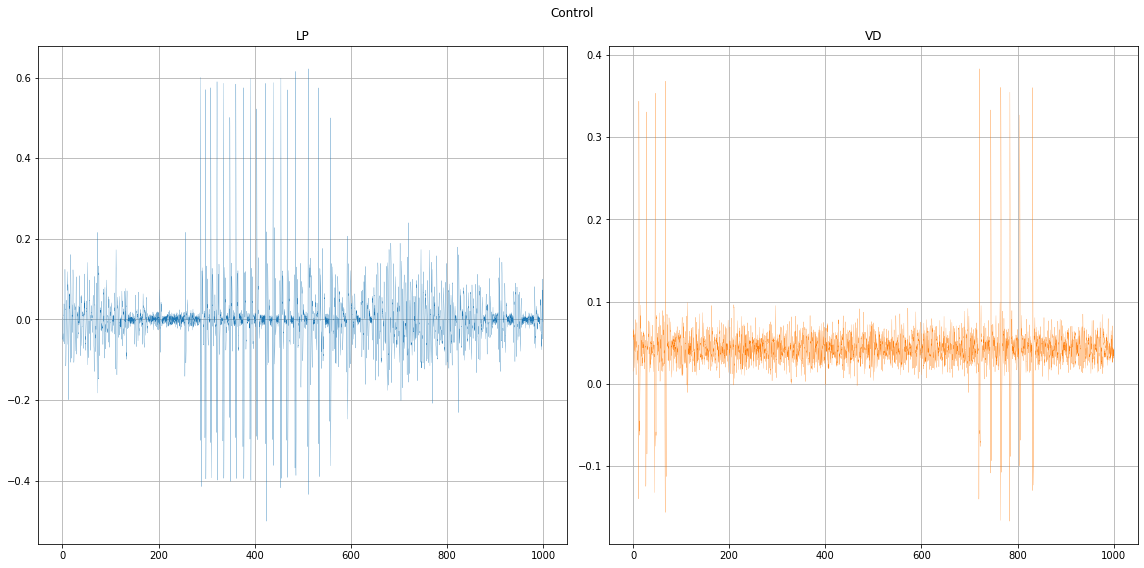

In [6]:
n = 10000
dt = 0.1
t = np.arange(0, n*dt, dt)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
fig.suptitle('Control')

ax1.grid(True)
ax1.plot(t,trozoC['LP'].iloc[:n],lw=0.2)
ax1.set_title("LP")

ax2.plot(t,trozoC['VD'].iloc[:n],'tab:orange',lw=0.2)
ax2.set_title("VD")
ax2.grid(True)

fig.tight_layout()

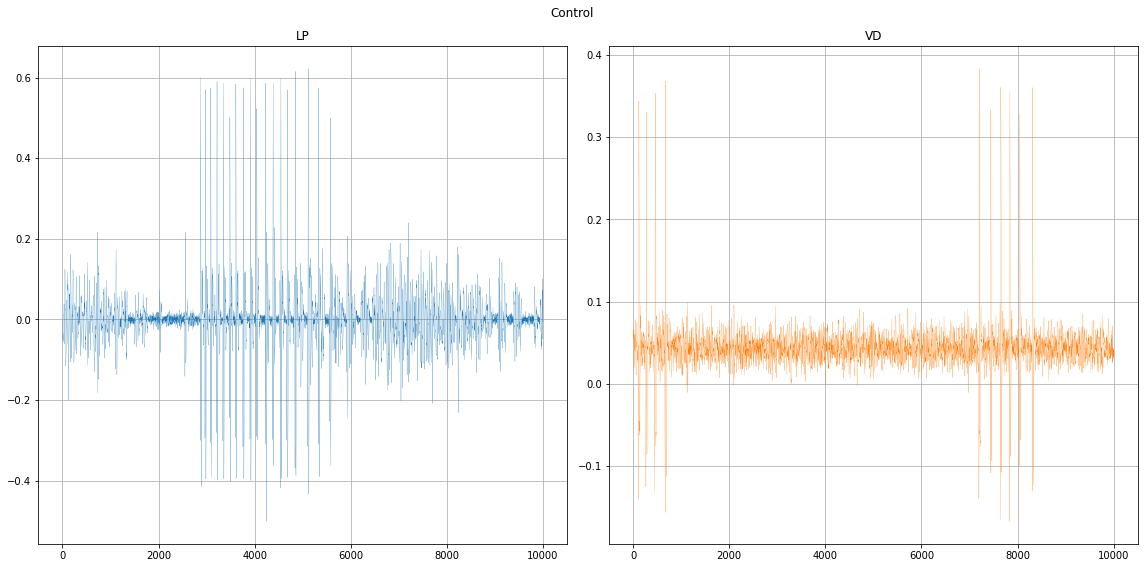

In [7]:

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
fig.suptitle('Control')

ax1.plot(trozoC['LP'].iloc[:n],lw=0.2)
ax1.set_title("LP")
ax1.grid(True)

ax2.plot(trozoC['VD'].iloc[:n],'tab:orange',lw=0.2)
ax2.set_title("VD")
ax2.grid(True)

fig.tight_layout()

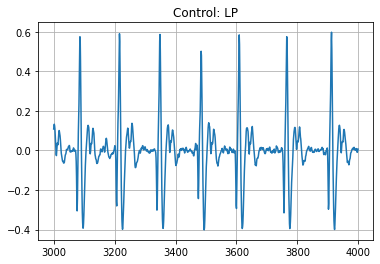

In [8]:
# Realizamos zoom a aquellos tiempos en los que se aprecian claramente los spikes
i = 3000
f = 4000

plt.plot(trozoC['LP'].iloc[i:f])
plt.title("Control: LP")
plt.grid(True)

Definir umbral para detectar outlier (i.e. spikes), realizar un kernel gaussiano (repasar transparencias el profe comentó algo de eso)

## Detección de Spikes

### Utilizando método estadístico

In [9]:
trozoC.describe()

,LP,VD
count,1.984770e+07,1.984770e+07
mean,-2.253853e-08,4.385849e-02
std,8.214042e-02,3.287948e-02
min,-7.101440e-01,-2.170715e+00
25%,-2.288800e-02,3.295900e-02
50%,3.050000e-04,4.364000e-02
75%,2.410900e-02,5.401600e-02
max,9.344480e-01,1.351624e+00


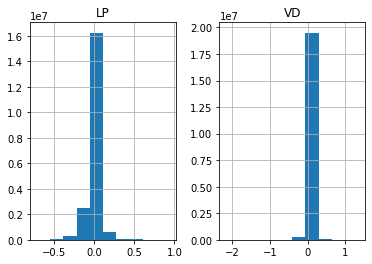

In [10]:
histogram = trozoC.hist()
plt.show()

In [11]:
def my_ceil(a, precision=0):
    return np.round(a + 0.5 * 10**(-precision), precision)

def get_threshold(df):
    return my_ceil(df.mean() + 4*df.std(),2)

In [12]:
threshold = get_threshold(trozoC)
threshold

LP    0.33
VD    0.18
dtype: float64

### Discretización

In [13]:
def discretize(df,threshold):
    return (df>threshold).astype(int)

In [14]:
trozoC_d = discretize(trozoC,threshold)
trozoC_d

,LP,VD
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
19847695,0,0
19847696,0,0
19847697,0,0
19847698,0,0


In [15]:
# Number of spikes detected
n_spikes = trozoC_d.sum()
n_spikes

LP    151648
VD    172514
dtype: int64

In [16]:
def get_spikes_index(df,column):
    return df[df[column]==1].index

In [17]:
spikes_lp_idx = get_spikes_index(trozoC_d,'LP')
spikes_vd_idx = get_spikes_index(trozoC_d,'VD')

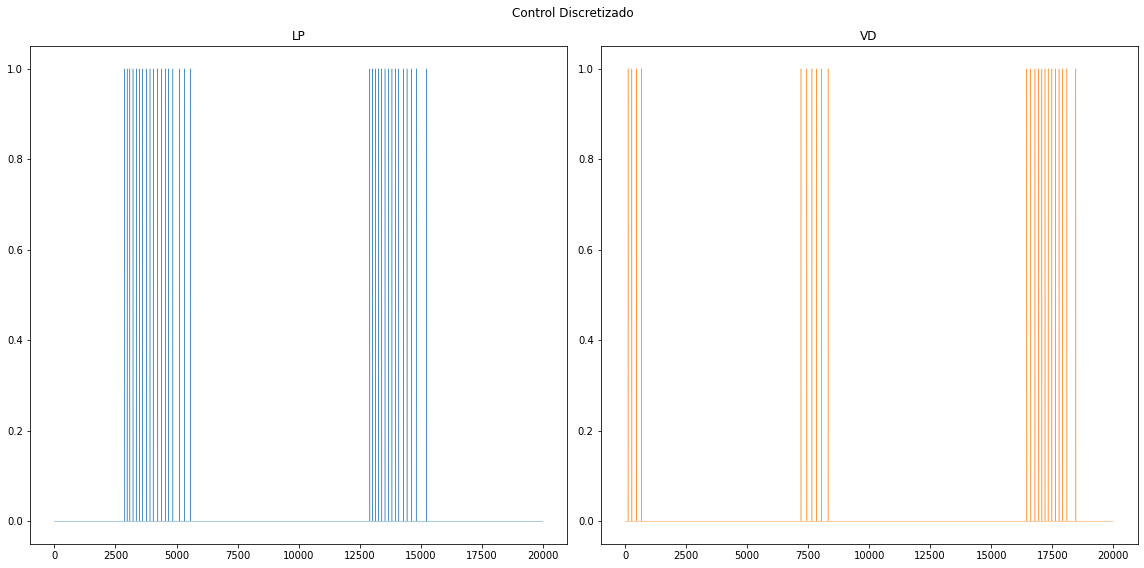

In [18]:
n = 20000

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
fig.suptitle('Control Discretizado')

ax1.plot(trozoC_d['LP'].iloc[:n],lw=0.4)
ax1.set_title("LP")

ax2.plot(trozoC_d['VD'].iloc[:n],'tab:orange',lw=0.4)
ax2.set_title("VD")

fig.tight_layout()

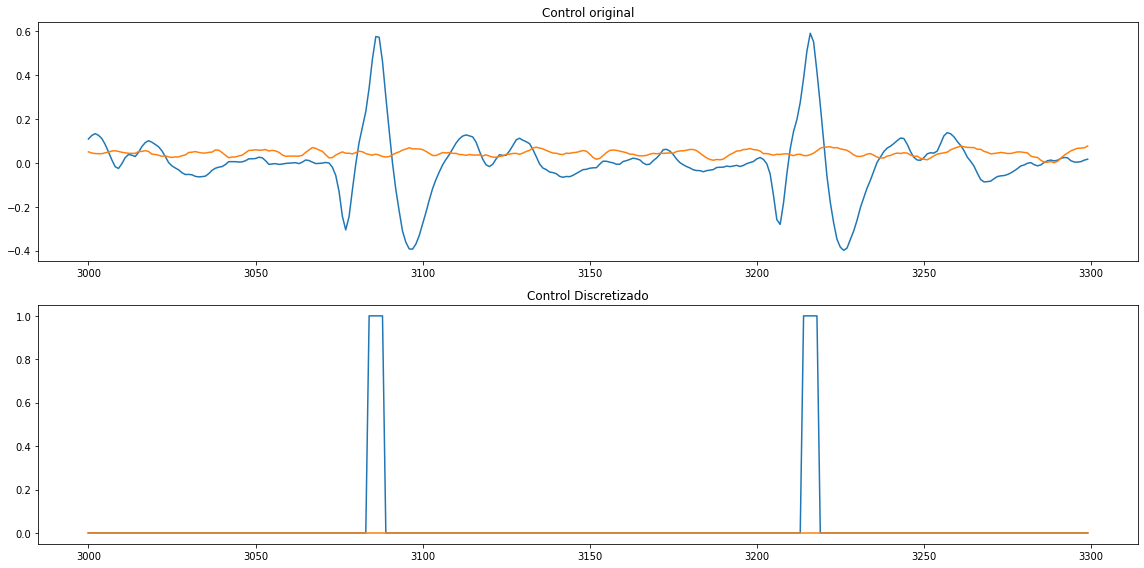

In [19]:
i = 3000
f = 3300

fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_size_inches(16, 8)
#fig.suptitle('Control Discretizado')

ax1.plot(trozoC['LP'].iloc[i:f])
ax1.plot(trozoC['VD'].iloc[i:f])
ax1.set_title("Control original")


ax2.plot(trozoC_d['LP'].iloc[i:f])
ax2.plot(trozoC_d['VD'].iloc[i:f],'tab:orange')
ax2.set_title("Control Discretizado")

fig.tight_layout()

## Tamaño de la ventana

In [20]:
control_lp_distances = np.diff(spikes_lp_idx)
control_vd_distances = np.diff(spikes_vd_idx)

print('Distancias MinMax entre spikes Control LP = ', np.amin(control_lp_distances),np.amax(control_lp_distances))
print('Distancias MinMax entre spikes Control VD = ', np.amin(control_vd_distances),np.amax(control_vd_distances))

Distancias MinMax entre spikes Control LP =  1 20755
Distancias MinMax entre spikes Control VD =  1 29903


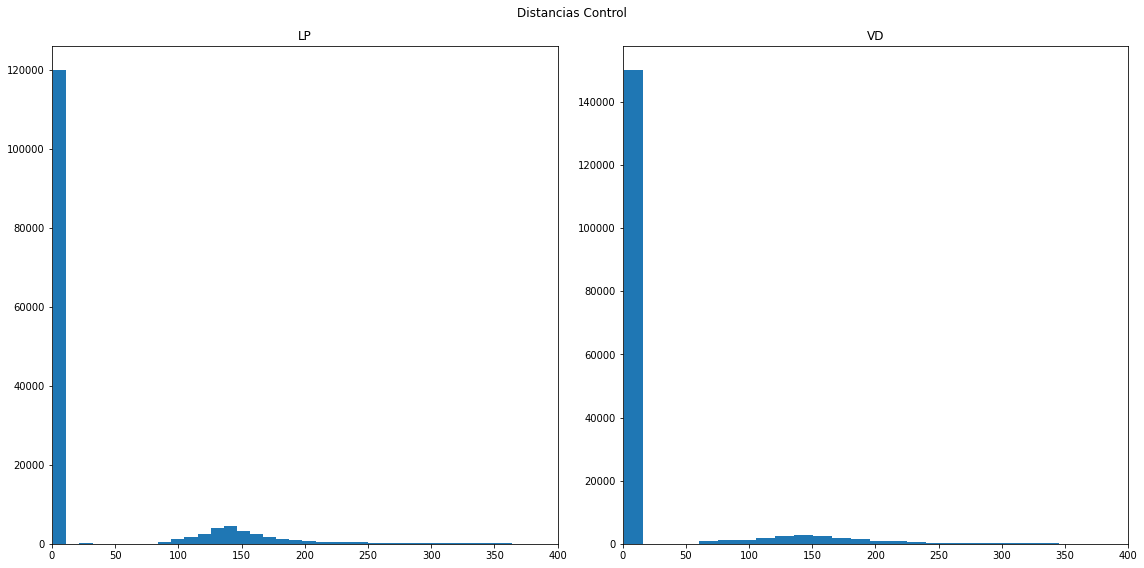

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
fig.suptitle('Distancias Control')

ax1.hist(control_lp_distances,bins=2000)
ax1.set_xlim((0, 400))
ax1.set_title("LP")


ax2.hist(control_vd_distances,bins=2000)
ax2.set_title("VD")
ax2.set_xlim((0, 400))

fig.tight_layout()

In [22]:
def get_spikes_idx_corrected(series,distances):
    to_remove = np.where(distances==1)
    return np.delete(series,to_remove)

In [23]:
spikes_lp_idx = get_spikes_idx_corrected(spikes_lp_idx,control_lp_distances)
spikes_vd_idx = get_spikes_idx_corrected(spikes_vd_idx,control_vd_distances)

In [24]:
control_lp_distances = np.diff(spikes_lp_idx)
lp_bin_size = np.amin(control_lp_distances)
print('Distancia mínima entre spike Control LP = ', lp_bin_size)


control_vd_distances = np.diff(spikes_vd_idx)
vd_bin_size = np.amin(control_vd_distances)
print('Distancia mínima entre spike Control VD = ', vd_bin_size)

Distancia mínima entre spike Control LP =  14
Distancia mínima entre spike Control VD =  5


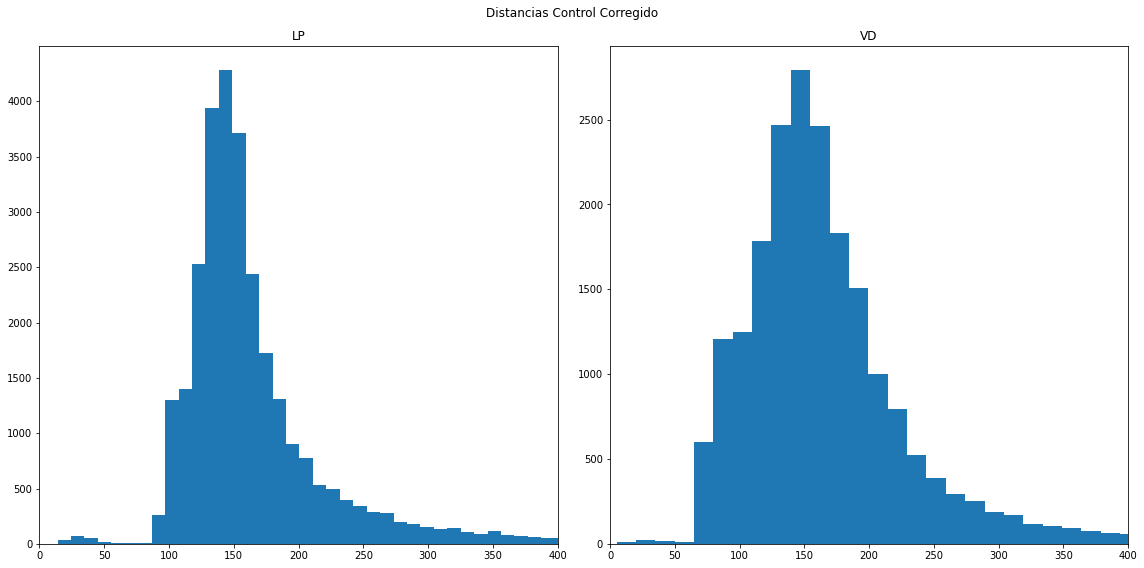

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
fig.suptitle('Distancias Control Corregido')

ax1.hist(control_lp_distances,bins=2000)
ax1.set_xlim((0, 400))
ax1.set_title("LP")

ax2.hist(control_vd_distances,bins=2000)
ax2.set_title("VD")
ax2.set_xlim((0, 400))

fig.tight_layout()

In [26]:
### PROBLEMA: LA MINIMA DISTANCIA ES 14 PERO HAY QUE MIRARLO EN TRASLACIONES, HAY QUE HACER OTRO EXPERIMENTO